In [205]:
import feos
import si_units as si
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.optimize import least_squares

In [295]:
#Critical temperature (Tc)	5.1953 K
#Critical pressure (Pc)	0.22832 MPa
#Critical density (Dc)	69.5800 kg/m3

tc = 5.1953

vle = pd.read_csv("data/helium_data/nist_vle.txt", sep="\t")
vle = vle[vle['Temperature (K)'] < 0.9 * tc][11:]
isotherms = pd.read_csv("data/helium_data/nist_isotherms.txt", sep="\t")

In [296]:
vle.head()

,Temperature (K),Pressure (MPa),"Density (l, kg/m3)","Volume (l, m3/kg)","Internal Energy (l, kJ/mol)","Enthalpy (l, kJ/mol)","Entropy (l, J/mol*K)","Cv (l, J/mol*K)","Cp (l, J/mol*K)","Sound Spd. (l, m/s)",...,"Internal Energy (v, kJ/mol)","Enthalpy (v, kJ/mol)","Entropy (v, J/mol*K)","Cv (v, J/mol*K)","Cp (v, J/mol*K)","Sound Spd. (v, m/s)","Joule-Thomson (v, K/MPa)","Viscosity (v, Pa*s)","Therm. Cond. (v, W/m*K)",Phase2
11,2.7268,0.015519,143.43,0.006972,-0.022153,-0.021719,-5.4656,8.0811,9.5070,225.51,...,0.051493,0.071844,28.847,12.452,23.270,91.779,15.702,7.092100e-07,0.0052791,vapor
12,2.7768,0.016896,143.06,0.006990,-0.021681,-0.021209,-5.2939,8.0594,9.6364,225.17,...,0.051911,0.072511,28.457,12.457,23.451,92.336,15.478,7.249700e-07,0.0053912,vapor
13,2.8268,0.018353,142.67,0.007009,-0.021204,-0.020689,-5.1230,8.0560,9.7872,224.69,...,0.052318,0.073161,28.077,12.463,23.642,92.875,15.261,7.408000e-07,0.0055034,vapor
14,2.8768,0.019894,142.26,0.007029,-0.020720,-0.020160,-4.9527,8.0672,9.9564,224.09,...,0.052716,0.073793,27.706,12.469,23.844,93.395,15.051,7.567000e-07,0.0056158,vapor
15,2.9268,0.021521,141.84,0.007050,-0.020227,-0.019620,-4.7825,8.0902,10.142,223.37,...,0.053103,0.074408,27.344,12.476,24.056,93.898,14.848,7.726800e-07,0.0057284,vapor


In [297]:
vle.columns#.Phase1.unique()

Index(['Temperature (K)', 'Pressure (MPa)', 'Density (l, kg/m3)',
       'Volume (l, m3/kg)', 'Internal Energy (l, kJ/mol)',
       'Enthalpy (l, kJ/mol)', 'Entropy (l, J/mol*K)', 'Cv (l, J/mol*K)',
       'Cp (l, J/mol*K)', 'Sound Spd. (l, m/s)', 'Joule-Thomson (l, K/MPa)',
       'Viscosity (l, Pa*s)', 'Therm. Cond. (l, W/m*K)',
       'Surf. Tension (l, N/m)', 'Phase1', 'Density (v, kg/m3)',
       'Volume (v, m3/kg)', 'Internal Energy (v, kJ/mol)',
       'Enthalpy (v, kJ/mol)', 'Entropy (v, J/mol*K)', 'Cv (v, J/mol*K)',
       'Cp (v, J/mol*K)', 'Sound Spd. (v, m/s)', 'Joule-Thomson (v, K/MPa)',
       'Viscosity (v, Pa*s)', 'Therm. Cond. (v, W/m*K)', 'Phase2'],
      dtype='object')

In [298]:
def vapor_pressure(model, args):
    result = []
    for t in args["temperature"]:
        try:
            vle = feos.PhaseEquilibrium.pure(model, t)
            psat = vle.vapor.pressure()
            result.append(psat)
        except:
            result.append(1e7 * si.PASCAL)
            
    return si.array(result)

def vapor_density(model, args):
    """
    args: temperature, pressure
    """
    result = []
    for t, p in zip(args["temperature"], args["pressure"]):
        density = feos.State(model, temperature=t, pressure=p, density_initialization="vapor").mass_density()
        result.append(density)
    return si.array(result)

def vle_liquid_densities(model, args):
    result = []
    for t in args["temperature"]:
        try:
            vle = feos.PhaseEquilibrium.pure(model, t)
            target = vle.liquid.mass_density()
            result.append(target)
        except:
            result.append(1000.0 * si.KILOGRAM / si.METER**3)
    return si.array(result)
    
psat_args = {
    "temperature": vle["Temperature (K)"].values * si.KELVIN,
    "target": vle["Pressure (MPa)"].values * si.MEGA * si.PASCAL,
}

rhol_eq_args = {
    "temperature": vle["Temperature (K)"].values * si.KELVIN,
    "target": vle["Density (l, kg/m3)"].values * si.KILOGRAM / si.METER**3,
}


rhov_args = {
    "temperature": isotherms["Temperature (K)"].values * si.KELVIN,
    "pressure": isotherms["Pressure (MPa)"].values * si.MEGA * si.PASCAL,
    "target": isotherms["Density (l, kg/m3)"].values * si.KILOGRAM / si.METER**3,
}

In [322]:
a, *b = [1, 2, 3]

In [324]:
b

[2, 3]

In [331]:
def model_from_parameter(parameter):
    if len(parameter) == 2:
        sigma, epsilon_k = parameter
        rep = 9
        pr = feos.PureRecord(
            identifier=feos.Identifier("helium"), 
            molarweight=4.002602, 
            rep=9,
            sigma=sigma,
            epsilon_k=epsilon_k,
            att=6
        )
    elif len(parameter) == 3:
        rep, sigma, epsilon_k = parameter
        pr = feos.PureRecord(
            identifier=feos.Identifier("helium"), 
            molarweight=4.002602, 
            rep=rep,
            sigma=sigma,
            epsilon_k=epsilon_k,
            att=6
        )
    else:
        c_rep = list(parameter[0:5])
        c_sigma = list(parameter[5:8])
        c_epsilon_k = list(parameter[8:])
        pr = feos.PureRecord(
            identifier=feos.Identifier("helium"), 
            molarweight=4.002602, 
            rep=9,
            sigma=2.7443,
            epsilon_k=5.4195,
            att=6,
            c_rep=c_rep,
            c_sigma=c_sigma,
            c_epsilon_k=c_epsilon_k
        )
    return feos.EquationOfState.uvcs(feos.Parameters.new_pure(pr))

def model_from_parameter_(parameter):
    if len(parameter) == 2:
        sigma, epsilon_k = parameter
        lr = 9
    else:
        lr, sigma, epsilon_k = parameter
    pr = feos.PureRecord(
        identifier=feos.Identifier("helium"), 
        molarweight=4.002602, 
        lr=lr,
        sigma=sigma,
        epsilon_k=epsilon_k,
        la=6,
        fh=1,
        m=1
    )
    return feos.EquationOfState.saftvrqmie(feos.Parameters.new_pure(pr))


def cost(parameter, args):
    model = model_from_parameter(parameter)

    residuals = []
    for fn, inp, res in args.values():
        prediction = fn(model, inp)
        target = inp["target"]
        if res == "ln":
            residual = np.log(prediction / target)
        elif res == "relative":
            residual = ((prediction - target) / target)
        else: 
            raise ValueError(f"{res} not known. Try [ln, relative]")
        residuals.append(residual)

    return np.concat(residuals)

In [332]:
args = {
    "psat": (vapor_pressure, psat_args, "ln"),
    "rhov": (vapor_density, rhov_args, "relative"),
    "rhol_eq": (vle_liquid_densities, rhol_eq_args, "relative"),
}

In [333]:
(feos.State.critical_point(model_from_parameter([9., 2.7443, 5.4195])).temperature / si.KELVIN)

5.221184445141771

In [334]:
vapor_pressure(model_from_parameter([9., 2.7443, 5.4195]), psat_args)

array([  3344.07033678,   3928.58710827,   4585.47340569,   5319.80181828,
         6136.67050756,   7041.19029204,   8038.47318688,   9133.62236812,
        10331.7235151 ,  11637.83747433,  13056.9941812 ,  14594.18777301,
        16254.37282669,  18042.46165625,  19963.32260956,  22021.77930884,
        24222.61078647,  26570.55247512,  29070.2980201 ,  31726.50189146,
        34543.7827838 ,  37526.72780396,  40679.89745901,  44007.83147248,
        47515.05547269,  51206.08861678,  55085.4522364 ,  59157.67961795,
        63427.32706308,  67898.98641476,  72577.29928432,  77466.97327768,
        82572.80059906,  87899.6795148 ,  93452.63929615,  99236.86944175,
       105257.75422501, 111520.91394649, 118032.2547365 ]) Pa

In [335]:
initial_guess = [1.0]*11
bounds = (0, np.inf)
#bounds = [(2.0, 4.0), (5.0, 10.0)]
fitted = least_squares(cost, initial_guess, bounds=bounds, args=(args, ), verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2486e+01                                    1.36e+02    
       1              2         1.7616e+00      1.07e+01       3.32e+00       3.64e+01    
       2              3         1.2623e-01      1.64e+00       6.63e+00       3.87e+00    
       3              4         1.7549e-02      1.09e-01       7.74e+00       7.71e-01    
       4              6         1.4838e-02      2.71e-03       2.37e+00       1.52e+00    
       5              7         1.2058e-02      2.78e-03       8.28e-02       5.65e-03    
       6             10         1.1336e-02      7.22e-04       1.63e-01       4.19e-02    
       7             11         1.0750e-02      5.86e-04       2.85e-01       7.66e-01    
       8             12         9.7316e-03      1.02e-03       3.17e-01       9.92e-02    
       9             13         9.0448e-03      6.87e-04       3.79e-01       4.46e-01    

In [336]:
fitted.x

array([6.02404167e-14, 7.12495981e+00, 3.21737527e-15, 2.89477886e-01,
       9.75553997e+00, 2.86000458e+00, 1.24715442e+01, 3.21256174e+00,
       5.18698202e-02, 1.06068091e-01, 3.27588753e-01])

In [342]:
psat_mard = np.mean(np.abs((psat_args["target"] - vapor_pressure(fitted_model, psat_args)) / psat_args["target"])) * 100
print(f"psat: {psat_mard:.2f} %")

psat: 0.14 %


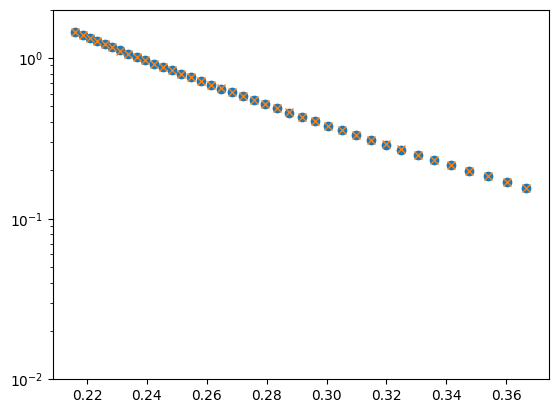

In [344]:
fitted_model = model_from_parameter(fitted.x)

plt.plot(
    1 / (psat_args["temperature"] / si.KELVIN),
    psat_args["target"] / si.BAR,
    "o"
)

plt.plot(
    1 / (psat_args["temperature"] / si.KELVIN),
    vapor_pressure(fitted_model, psat_args) / si.BAR,
    "x"
)

plt.ylim(1e-2, 2)
plt.yscale("log")

In [338]:
dia = pd.DataFrame(feos.PhaseDiagram.pure(fitted_model, 2.7 * si.KELVIN, 250).to_dict(feos.Contributions.Residual))

In [339]:
dia

,temperature,pressure,density liquid,density vapor,molar enthalpy liquid,molar enthalpy vapor,molar entropy liquid,molar entropy vapor,mass density liquid,mass density vapor,specific enthalpy liquid,specific enthalpy vapor,specific entropy liquid,specific entropy vapor
0,2.700000,14764.520593,35511.278632,726.046692,-0.099605,-0.004685,-0.002980,-0.000167,142.137515,2.906076,-24.885117,-1.170445,-0.744410,-0.041739
1,2.710059,15028.218123,35504.017576,737.077818,-0.099699,-0.004750,-0.002988,-0.000168,142.108452,2.950229,-24.908466,-1.186834,-0.746428,-0.042042
2,2.720119,15295.082902,35496.455843,748.215956,-0.099792,-0.004817,-0.002996,-0.000169,142.078185,2.994811,-24.931772,-1.203368,-0.748450,-0.042347
3,2.730178,15565.133699,35488.594980,759.461664,-0.099885,-0.004883,-0.003004,-0.000171,142.046721,3.039823,-24.955031,-1.220048,-0.750474,-0.042654
4,2.740237,15838.389271,35480.436504,770.815499,-0.099978,-0.004951,-0.003012,-0.000172,142.014066,3.085268,-24.978242,-1.236875,-0.752502,-0.042963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,5.164534,220234.057030,20385.229268,13071.158974,-0.087649,-0.064359,-0.002334,-0.001519,81.593959,52.318647,-21.897977,-16.079324,-0.583058,-0.379543
246,5.174593,221891.783309,19892.976394,13509.200908,-0.086298,-0.065978,-0.002275,-0.001566,79.623667,54.071955,-21.560415,-16.483894,-0.568473,-0.391318
247,5.184653,223559.788278,19299.569748,14044.280582,-0.084632,-0.067912,-0.002206,-0.001624,77.248496,56.213666,-21.144296,-16.966956,-0.551116,-0.405698
248,5.194712,225238.166355,18514.509288,14766.135801,-0.082366,-0.070445,-0.002115,-0.001702,74.106212,59.102965,-20.578054,-17.599871,-0.528521,-0.425125


In [340]:
vle.columns

Index(['Temperature (K)', 'Pressure (MPa)', 'Density (l, kg/m3)',
       'Volume (l, m3/kg)', 'Internal Energy (l, kJ/mol)',
       'Enthalpy (l, kJ/mol)', 'Entropy (l, J/mol*K)', 'Cv (l, J/mol*K)',
       'Cp (l, J/mol*K)', 'Sound Spd. (l, m/s)', 'Joule-Thomson (l, K/MPa)',
       'Viscosity (l, Pa*s)', 'Therm. Cond. (l, W/m*K)',
       'Surf. Tension (l, N/m)', 'Phase1', 'Density (v, kg/m3)',
       'Volume (v, m3/kg)', 'Internal Energy (v, kJ/mol)',
       'Enthalpy (v, kJ/mol)', 'Entropy (v, J/mol*K)', 'Cv (v, J/mol*K)',
       'Cp (v, J/mol*K)', 'Sound Spd. (v, m/s)', 'Joule-Thomson (v, K/MPa)',
       'Viscosity (v, Pa*s)', 'Therm. Cond. (v, W/m*K)', 'Phase2'],
      dtype='object')

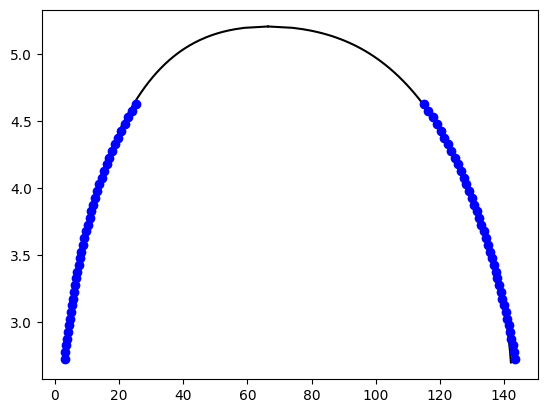

In [341]:
plt.plot(dia["mass density liquid"], dia["temperature"], "k")
plt.plot(dia["mass density vapor"], dia["temperature"], "k")
plt.plot(vle["Density (l, kg/m3)"], vle['Temperature (K)'], "bo")
plt.plot(vle["Density (v, kg/m3)"], vle['Temperature (K)'], "bo");

In [320]:
thijs = dict(
    sigma=2.7362991828156673,
    epsilon_k=5.390493085958323,
    rep=9.008494804971958,
    att=6.0,
)

ailo = dict(sigma=2.7443, epsilon_k=5.4195, rep=9, att=6, c_sigma=[1.0]*3, c_epsilon_k=[1.0]*3, c_rep=[1.0]*5)
vrqmie_ailo = dict(m=1.0, sigma=2.7443, epsilon_k=5.4195, lr=9, la=6, fh=1)

In [11]:
vrq_pr = feos.PureRecord(identifier=feos.Identifier("helium"), molarweight=4.002602, **vrqmie_ailo)
pr = feos.PureRecord(identifier=feos.Identifier("helium"), molarweight=4.002602, **ailo)

In [12]:
cs_model = feos.EquationOfState.uvcs(feos.Parameters.new_binary([pr]*2))
vrq_model = feos.EquationOfState.saftvrqmie(feos.Parameters.new_pure(vrq_pr))

In [104]:
feos.State.critical_point(cs_model, molefracs=np.array([0.5]*2), initial_temperature=si.KELVIN, verbosity=feos.Verbosity.Iter)

 iter |    residual    |   temperature   |       density        
----------------------------------------------------------------
    0 |                |    1.00000000 K |  23.01690777 kmol/m³
    1 |   1.09731018e2 |    1.25000000 K |  21.96392253 kmol/m³
    2 |   4.88702479e1 |    1.56250000 K |  20.18128818 kmol/m³
    3 |   2.23545604e1 |    1.82017883 K |  17.87959740 kmol/m³
    4 |   1.04163842e1 |    1.78001131 K |  15.57790663 kmol/m³
    5 |   5.99173423e0 |    1.39287997 K |  13.27621585 kmol/m³
    6 |   1.49364268e0 |    1.27328192 K |  13.03641202 kmol/m³
    7 |  6.90573134e-1 |    1.30040928 K |  13.08852382 kmol/m³
    8 |  5.41669290e-2 |    1.30295529 K |  13.09297769 kmol/m³
    9 |  4.19136722e-4 |    1.30297553 K |  13.09300980 kmol/m³
   10 |  2.60795516e-8 |    1.30297553 K |  13.09300980 kmol/m³
   11 | 5.90091632e-15 |    1.30297553 K |  13.09300980 kmol/m³
Critical point calculation converged in 11 step(s)



|temperature|density|molefracs
|-|-|-|
|1.30298 K|13.09301 kmol/m³|[0.50000, 0.50000]|

In [91]:
%%time
df_cs = feos.PhaseDiagram.pure(cs_model, min_temperature=2*si.KELVIN, npoints=250).to_dict(feos.Contributions.Residual)

CPU times: user 27.9 ms, sys: 1.31 ms, total: 29.3 ms
Wall time: 31.6 ms


In [92]:
%%time
df_vrq = feos.PhaseDiagram.pure(vrqmie_model, min_temperature=2*si.KELVIN, npoints=250).to_dict(feos.Contributions.Residual)

CPU times: user 113 ms, sys: 1.46 ms, total: 114 ms
Wall time: 115 ms


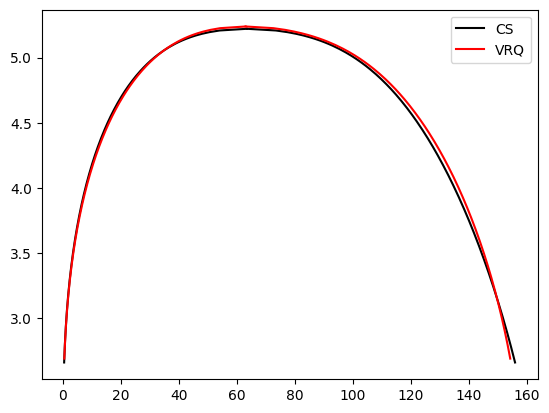

In [93]:
plt.plot(df_cs["mass density liquid"], df_cs["temperature"], 'k', label="CS")
plt.plot(df_cs["mass density vapor"], df_cs["temperature"], 'k')
plt.plot(df_vrq["mass density liquid"], df_vrq["temperature"], 'r', label="VRQ")
plt.plot(df_vrq["mass density vapor"], df_vrq["temperature"], 'r')
plt.legend();